In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import os
import inspect
import math
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir)
from src.Tools import generate_inputWN,moving_bump

# 1 Fit output of RNN

In [2]:
n_step=41
dim_rec=300

Define an interesting 2-d sequential output pattern:

In [3]:
target=np.zeros((41,2))
for i in range(8):
    target[i,0]=1*np.cos(np.pi-np.pi/5*i)+1
    target[i,1]=1*np.sin(np.pi-np.pi/5*i)
target[8,0]=0.8
target[8,1]=-1.3
target[9,0]=0.4
target[9,1]=-1.6
for i in range(10,15):
    target[i,0]=target[0,0]+0.5*(i-10)
    target[i,1]=-2
for i in range(15,25):
    target[i,0]=1*np.cos(-np.pi/2-np.pi/5*(i-15))+3.7
    target[i,1]=1.5*np.sin(-np.pi/2-np.pi/5*(i-15))-0.5
for i in range(25,34):
    target[i,0]=2/1.8*np.cos(np.pi*6/5+np.pi/5*(i-25))+6.4
    target[i,1]=1*np.sin(np.pi*6/5+np.pi/5*(i-25))-1
target[34:36,0]=target[33,0]
target[34:36,1]=np.linspace(target[33,1],1,4)[1:3]
for i in range(36,41):
    target[i,0]=target[35,0]+0.5*(i-36)
    target[i,1]=1
target=target[:n_step,:].T

Text(0, 0.5, 'y')

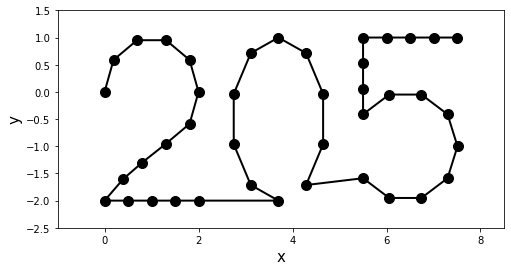

In [4]:
fig,ax=plt.subplots(figsize=(8,4))
plt.plot(target[0,:],target[1,:],marker='o',ms=10,c='k',lw=2)
plt.xlim(-1,8.5)
plt.ylim(-2.5,1.5)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)

Use filtered white noise as the inputs to the RNN - it is a rich source of dynamics

In [5]:
inputs=generate_inputWN(n_step=n_step,dim_rec=dim_rec,tauWN=1,ampWN=30,dt=0.001).astype('float32')

In [6]:
x0=np.zeros(dim_rec)
J= 0.9 * np.random.randn(dim_rec, dim_rec) / math.sqrt(dim_rec)
Wfb = 0.9 * np.random.randn(dim_rec, target.shape[0]) / math.sqrt(target.shape[0])
def rnnLN(W):
    pred=np.zeros(target.shape)
    for i in range(n_step):
        if i == 0:
            x = x0
        else:
            x = np.dot(J, np.tanh(x)) + np.dot(Wfb,output)+ inputs[:,i] 
        output=np.dot(W, np.tanh(x))
        pred[:,i]=output
    return pred
def loss(W):
    W=W.reshape(-1,dim_rec)
    pred=rnnLN(W)
    return np.mean(np.square(target-pred))

In [8]:
history=[]
n=0
def callback(x):
    W=x.reshape(-1,dim_rec)
    pred=rnnLN(W)
    history.append(np.mean(np.square(target-pred)))
    print(f'iteration{len(history)}:{history[-1]}')
    if len(history)>=2 and history[-1]-history[-2]>1e-10:
        return False

In [9]:
W0 =np.zeros((target.shape[0],dim_rec))

In [10]:
res = minimize(fun=loss, x0=W0.flatten(), method='BFGS',  jac="2-point", hess='2-point',tol=1e-16,
                        callback=callback,options={'maxiter':1000,'disp':True})

/home/sz154/jupyterenv/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


iteration1:6.400147692196263
iteration2:3.5237423852455403
iteration3:2.79768785599616
iteration4:2.756973380929531
iteration5:2.421127765878052
iteration6:1.0358876791442095
iteration7:1.0350333626373236
iteration8:1.0030361158426468
iteration9:0.9467316805546577
iteration10:0.8493681642039417
iteration11:0.7066326557609581
iteration12:0.6887804470617296
iteration13:0.6643328301094902
iteration14:0.6260757306855302
iteration15:0.5830720539306673
iteration16:0.5681400240245357
iteration17:0.5543503597059587
iteration18:0.5357404268743999
iteration19:0.5137188339805425
iteration20:0.49199110393630147
iteration21:0.473630541669513
iteration22:0.450104326467519
iteration23:0.43951810446365513
iteration24:0.42296351760290235
iteration25:0.408744910275873
iteration26:0.3868495579500268
iteration27:0.3644345233280301
iteration28:0.36129724859314744
iteration29:0.35557028286752224
iteration30:0.3484841540881558
iteration31:0.34042489563763745
iteration32:0.33220064922320586
iteration33:0.3213

iteration248:0.0006036441921400061
iteration249:0.0005921050673490543
iteration250:0.0005814072583684959
iteration251:0.000569362732503765
iteration252:0.0005615370948206145
iteration253:0.0005539500470403504
iteration254:0.0005495722680607149
iteration255:0.0005434436755206839
iteration256:0.0005340961700824892
iteration257:0.0005198823292842343
iteration258:0.0005101551229207322
iteration259:0.0004993480888411042
iteration260:0.0004933011755612496
iteration261:0.00048456512296718315
iteration262:0.00047606491285594486
iteration263:0.0004643769987630104
iteration264:0.0004510454229243901
iteration265:0.0004456715113038159
iteration266:0.00043722929524682473
iteration267:0.00042860415117633536
iteration268:0.0004252569246279371
iteration269:0.00042210560062213784
iteration270:0.0004187318811011283
iteration271:0.0004160856324109835
iteration272:0.0004119052308739576
iteration273:0.0004051365592513675
iteration274:0.00039526303379767606
iteration275:0.000385189592991854
iteration276:0.0

In [11]:
W=res['x'].reshape(-1,dim_rec)

In [12]:
pred=rnnLN(W)

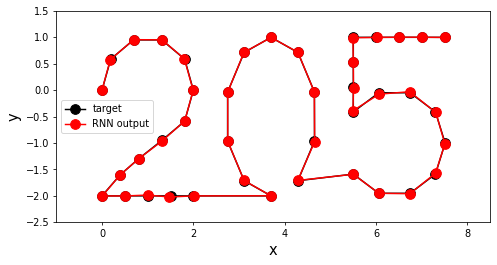

In [19]:
fig,ax=plt.subplots(figsize=(8,4),dpi=70)
plt.plot(target[0,:],target[1,:],marker='o',ms=10,c='k',label='target')
plt.plot(pred[0,:],pred[1,:],marker='o',ms=10,c='r',label='RNN output')
plt.xlim(-1,8.5)
plt.ylim(-2.5,1.5)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.legend(loc=6)

In [20]:
RLS_lc=np.load(f'/home/sz154/mse_lc.npy',allow_pickle=True)

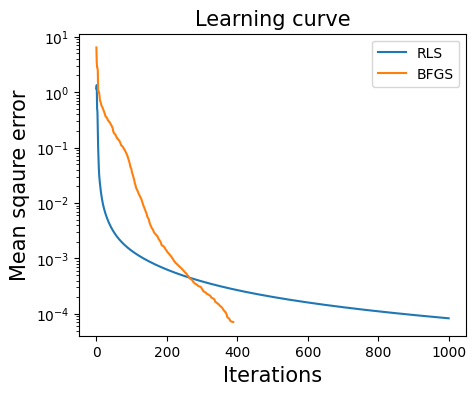

In [22]:
fig,ax=plt.subplots(figsize=(5,4),dpi=100)
plt.plot(RLS_lc,label='RLS')
plt.plot(history,label='BFGS')

plt.yscale('log')
plt.xlabel('Iterations',size=15)
plt.ylabel('Mean sqaure error',size=15)
plt.title('Learning curve',size=15)
plt.legend()
